<a href="https://colab.research.google.com/github/cristi2019255/DigitRecognition/blob/main/Pattern_recognition_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import 	LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, recall_score, precision_score, f1_score

##Loading data

First add the data in .csv format in your google drive

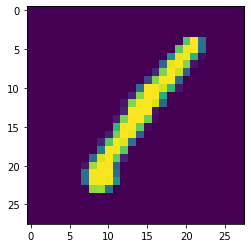

In [3]:
# reading the data set
mnist_data = pd.read_csv('/content/drive/MyDrive/Pattern_recognition_assignment_1/mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
plt.imshow(digits[0].reshape(img_size, img_size))
plt.show()

## Data analisys and preprocessing

{0: 0.09838095238095237, 1: 0.11152380952380953, 2: 0.09945238095238096, 3: 0.1035952380952381, 4: 0.09695238095238096, 5: 0.09035714285714286, 6: 0.0985, 7: 0.10478571428571429, 8: 0.09673809523809523, 9: 0.09971428571428571}
0.11152380952380953


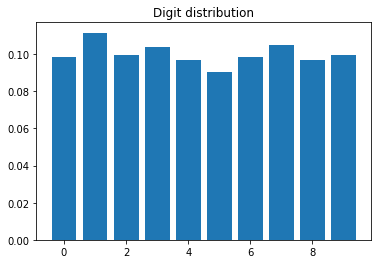

In [4]:
# Data consists of 42k rows representing a digit from 0-9, and 784 columns
# representing a pixel and the corresponding grey value (0-255). 
unique_digits, counts = np.unique(labels, return_counts=True)
N = len(labels) # 42k in our case representing the size of the sample of handwritten digits.
rel_freq = list(map(lambda n : n/N, counts))
distribution = dict(zip(unique_digits, rel_freq))
print(distribution)
print(max(distribution.values()))
plt.title("Digit distribution")
bar = plt.bar(unique_digits,[counts[i] / 42000 for i in range(10)])

1) If we predict the majority class (namely class 1) then 11.152 % of data will be classified correctly


In [5]:
# overlay all matrices to spot the useless pixels
def overlay_matrices(digits, percent_trashhold = 0.01):
  N = len(digits)  
  final_img = np.reshape(digits[0], (28, 28)) 
  for digit in digits[1:]:    
    img = np.reshape(digit, (28, 28))
    final_img = np.add(final_img, img)      
  final_img = final_img / 255    
  final_img[final_img < (percent_trashhold * N)] = 0.0    
  return final_img

# finding the empty rows and columns indices
def filter_empty(img):  
  # summing other the rows to spot an empty row
  trash_rows = []
  sums_rows = img.sum(axis=1)
  for x in range(len(sums_rows)):
    if sums_rows[x] == 0:
      trash_rows.append(x)

  # summing other the columns to spot an empty column
  trash_columns = []  
  sums_columns = img.sum(axis=0)
  for x in range(len(sums_columns)):
    if sums_columns[x] == 0:
      trash_columns.append(x)
  
  return trash_rows, trash_columns

# reshaping from flatten representation to 28x28 ndarray representation
def reshape_dataset(digits, img_size = 28):
  return np.array([np.reshape(sample, (img_size, img_size))  for sample in digits])

# remove (almost) empty row/colums from the images
def preprocess_dataset(digits, delete_empty = True):
  dataset = reshape_dataset(digits)    
  if delete_empty:
    rows_to_del, cols_to_del = filter_empty(overlay_matrices(dataset))
    print(rows_to_del, cols_to_del)
    
    '''
      intersecting rows indexes and column indexes that can be deleted
      to obtain a square image when deleting rows and columns
    '''
    filtered_delete = [value for value in rows_to_del if value in cols_to_del]
    new_img_size = img_size - len(filtered_delete)  

    proccessed_dataset = []
    for img in dataset:    
      img = np.delete(img, filtered_delete, 0)
      img = np.delete(img, filtered_delete, 1)
      proccessed_dataset.append(img)

    return proccessed_dataset, new_img_size
  return dataset, 28

In [6]:
# preprocessing data set
digits_original = digits
digits, img_size = preprocess_dataset(digits)
print(len(digits), img_size)
print(f'image shape {digits[0].shape}')

[0, 1, 27] [0, 1, 2, 3, 25, 26, 27]
42000 25
image shape (25, 25)


In [7]:
# utils to plot confusion matrix
def plot_conf_matrix(conf_matrix, title):  
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix'+title, fontsize=15)
  plt.show()

## Feature extraction

Ink usage extraction time 6.292642831802368 sec


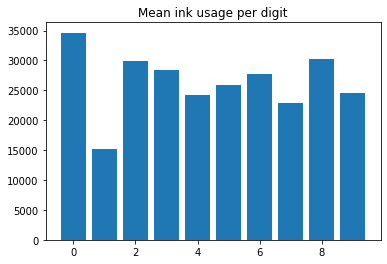

In [8]:
# Creating ink feature
start = time.time()
ink = np.array([sum(digit.flatten()) for digit in digits])
end = time.time()
print(f'Ink usage extraction time {end-start} sec')

# Computing mean for each digit class
ink_mean = [np.mean(ink[labels == i]) for i in range(10)]

# Computing standard deviation for each digit class
ink_std = [np.std(ink[labels == i]) for i in range(10)]

# The reshape is neccesary to call LogisticRegression() with a single feature
# Scaling the feature to 0 mean and 1 standard deviation
ink = scale(ink).reshape(-1, 1)

plt.title("Mean ink usage per digit")
bar = plt.bar(unique_digits,ink_mean)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


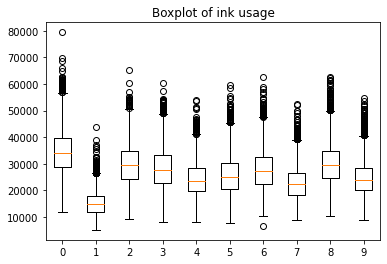

In [9]:
# Making a boxplot of ink usage feature
ink_digits = [[], [], [], [], [], [], [], [], [], []]
for i in range(N):  
  ink_digits[labels[i]].append(sum(digits[i].flatten()))

plt.boxplot(ink_digits, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.title("Boxplot of ink usage")
plt.show()

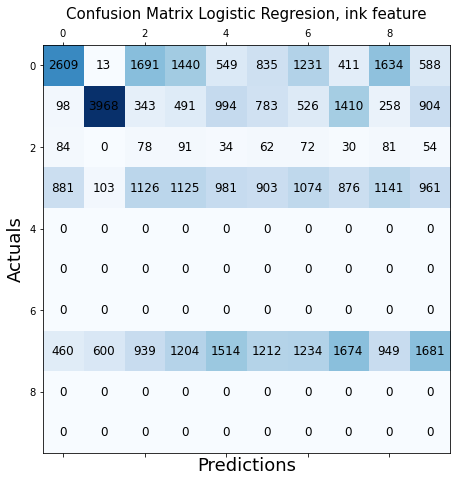

[[2609   13 1691 1440  549  835 1231  411 1634  588]
 [  98 3968  343  491  994  783  526 1410  258  904]
 [  84    0   78   91   34   62   72   30   81   54]
 [ 881  103 1126 1125  981  903 1074  876 1141  961]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 460  600  939 1204 1514 1212 1234 1674  949 1681]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


0.2250952380952381

In [50]:
# Training and Testing the Logistic Regression model on ink usage feature
# extracted from the whole data set
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1', random_state=0).fit(ink,labels)
y_pred = logistic_regression.predict(ink)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' Logistic Regresion, ink feature')
print(conf_matrix)
accuracy_score(y_pred, labels)

Ink feature gives only 22.68 % accuracy

In [51]:
'''
Spliting each image in non-overlapping blocks
'''
def split_blocks(img, kernel_size = (7,7)):
  blocks = [img[x:x+kernel_size[0],y:y+kernel_size[1]] for x in range(0,img.shape[0],kernel_size[0]) for y in range(0,img.shape[1],kernel_size[1])]  
  return blocks

"""
 Calculating ink usage for each block 
"""
def ink_blocks(blocks):  
  return np.array([sum(sum(block)) for block in blocks])

In [52]:
# Extracting ink_usage_per_blocks feature
start = time.time()
ink_blocks_features = np.array([ink_blocks(split_blocks(x, kernel_size = (5,5))) for x in digits])
end = time.time()
print(f'Ink per blocks extraction time {end-start} sec')

Ink per blocks extraction time 11.12473464012146 sec


In [53]:
# scaling
ink_blocks_features = scale(ink_blocks_features)
print(ink_blocks_features.shape)

(42000, 25)


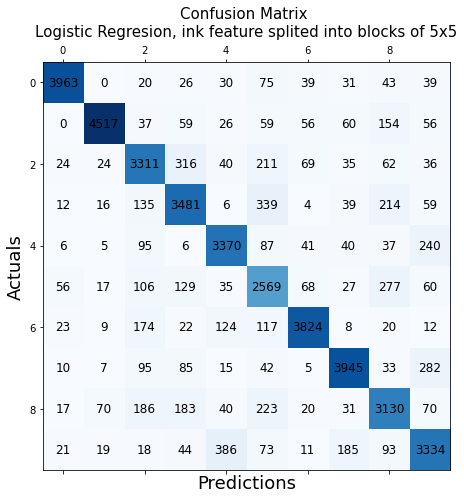

[[3963    0   20   26   30   75   39   31   43   39]
 [   0 4517   37   59   26   59   56   60  154   56]
 [  24   24 3311  316   40  211   69   35   62   36]
 [  12   16  135 3481    6  339    4   39  214   59]
 [   6    5   95    6 3370   87   41   40   37  240]
 [  56   17  106  129   35 2569   68   27  277   60]
 [  23    9  174   22  124  117 3824    8   20   12]
 [  10    7   95   85   15   42    5 3945   33  282]
 [  17   70  186  183   40  223   20   31 3130   70]
 [  21   19   18   44  386   73   11  185   93 3334]]


0.8439047619047619

In [54]:
'''
 Training and Testing the Logistic Regression model on ink usage per blocks
 feature extracted from the whole data set
'''
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1', random_state=0).fit(ink_blocks_features,labels)
y_pred = logistic_regression.predict(ink_blocks_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion, ink feature splited into blocks of 5x5')
print(conf_matrix)
accuracy_score(y_pred, labels)

In [55]:
# create The Contour feature
def starting_point(x):
    '''
      x - a matrix (ndarray)
      output - coordinates of the starting point
      Starting point is the first value(pixel) in the matrix x that is not 0
      when iterating the matrix in spiral form
    '''
    k = 0
    l = 0
    n, m = len(x), len(x[0])
  
    ''' k - starting row index 
        m - ending row index 
        l - starting column index 
        n - ending column index 
        i - iterator 
    '''     
  
    while (k < m and l < n) : 
          
        # Iterate first row from 
        # the remaining rows  
        for i in range(l, n) : 
            if (x[k][i]>0):
              return k,i              
        k += 1
  
        # Iterate last column from 
        # the remaining columns  
        for i in range(k, m) : 
            if (x[i][n-1]>0):
              return i, n - 1                            
        n -= 1
  
        # Iterate the last row from 
        # the remaining rows  
        if ( k < m) :               
            for i in range(n - 1, (l - 1), -1) : 
                if (x[m-1][i]>0):
                  return m-1,i                
              
            m -= 1
          
        # Iterate the first column from 
        # the remaining columns  
        if (l < n) : 
            for i in range(m - 1, k - 1, -1) : 
              if (x[i][l]>0):
                  return i,l                              
            l += 1

    # if no starting point is found then returning -1, -1            
    return -1, -1    

def calculate_histogram(x, s_x, s_y):  
  """
    Calculating histogram of pixels occurances in 8 directions
    from the starting point.
    x - matrix (img of type ndarray)
    s_x, s_y - coordinates of the starting point
  """
  
  [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7] = [0] * 8
  
  if (s_x == -1) and (s_y == -1):
    return [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7]

  n, m  = len(x), len(x[0])

  '''direction 0 right'''  
  if (s_y < m ):
    d_0 = sum(x[s_x][s_y+1:])   

  '''direction 1 up-right'''  
  if (s_y < m) and (s_x > 0):
    j = s_y    
    for i in range(s_x, 0,-1):      
      d_1 += x[i][j]       
      if (j == m-1):
        break 
      j += 1
    d_1 -= x[s_x][s_y]
  
  '''direction 2 up'''  
  if (s_x > 0 ):
    d_2 = sum([x[i][s_y] for i in range(s_x)])    
   
  '''direction 3 up-left'''  
  if (s_y > 0 ) and (s_x > 0):
    j = s_y
    for i in range(s_x, 0,-1):
      d_3 += x[i][j]       
      if (j == 0):
        break 
      j -= 1
    d_3 -= x[s_x][s_y]

  '''direction 4 left'''  
  if (s_y > 0 ):
    d_4 = sum(x[s_x][:s_y])    

  '''direction 5 down-left'''  
  if (s_y > 0 ) and (s_x < n):
    j = s_y 
    for i in range(s_x, n):
      d_5 += x[i][j]       
      if (j == 0):
        break 
      j -= 1
    d_5 -= x[s_x][s_y]  

  '''direction 6 down'''  
  if (s_x < n ):
    d_6 = sum([x[i][s_y] for i in range(s_x + 1,n)])    
     
  '''direction 7 down-right'''  
  if (s_y < m ) and (s_x < n):
    j = s_y 
    for i in range(s_x, n):
      d_7 += x[i][j]       
      if (j == m - 1):
        break 
      j += 1
    d_7 -= x[s_x][s_y]

  return [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7]

def extract_contur_features(dataset, kernel_size = (5,5)):
  """
    extracting contur features from dataset
    output: features - a list of feature_vectors       
  """
  features = []
  for img in dataset:    
    feature_vector = []    
    # converting image from grayscale to binary
    (_, img) = cv2.threshold(img.astype('uint8'), 127, 255, cv2.THRESH_BINARY)    

    # splitting image into blocks of size kernel size
    blocks = split_blocks(img, kernel_size= kernel_size)

    # for each block search for starting point, calculate histogram of occurances
    # append histogram to feature vector
    for block in blocks:    
        s_x, s_y  = starting_point(block)
        feature_vector += calculate_histogram(block, s_x, s_y)        
    
    features.append(feature_vector)

  return features

In [56]:
'''
 Extracting contour features from the data set
'''
start = time.time()
contur_features = extract_contur_features(digits, kernel_size=(5,5))
end = time.time()
print(f'Contour feature extraction time {end-start} sec')

Contour feature extraction time 50.78761315345764 sec


In [57]:
# scaling contur features to 0 mean and unit standard deviation
contur_features = scale(np.array(contur_features))
print(np.array(contur_features).shape)

(42000, 200)


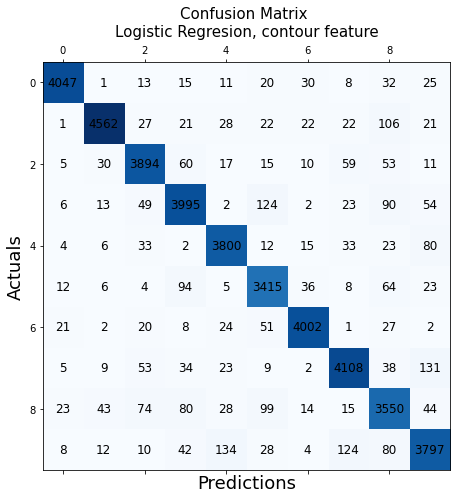

[[4047    1   13   15   11   20   30    8   32   25]
 [   1 4562   27   21   28   22   22   22  106   21]
 [   5   30 3894   60   17   15   10   59   53   11]
 [   6   13   49 3995    2  124    2   23   90   54]
 [   4    6   33    2 3800   12   15   33   23   80]
 [  12    6    4   94    5 3415   36    8   64   23]
 [  21    2   20    8   24   51 4002    1   27    2]
 [   5    9   53   34   23    9    2 4108   38  131]
 [  23   43   74   80   28   99   14   15 3550   44]
 [   8   12   10   42  134   28    4  124   80 3797]]
0.9326190476190476


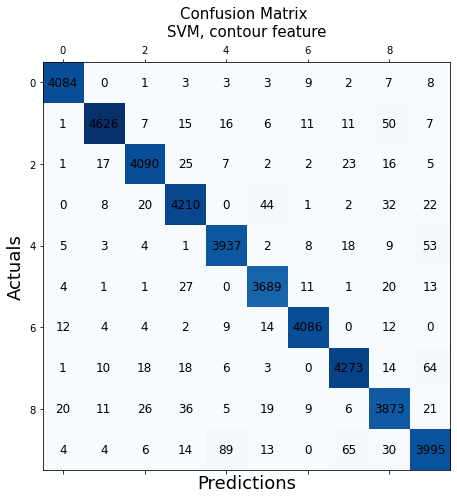

[[4084    0    1    3    3    3    9    2    7    8]
 [   1 4626    7   15   16    6   11   11   50    7]
 [   1   17 4090   25    7    2    2   23   16    5]
 [   0    8   20 4210    0   44    1    2   32   22]
 [   5    3    4    1 3937    2    8   18    9   53]
 [   4    1    1   27    0 3689   11    1   20   13]
 [  12    4    4    2    9   14 4086    0   12    0]
 [   1   10   18   18    6    3    0 4273   14   64]
 [  20   11   26   36    5   19    9    6 3873   21]
 [   4    4    6   14   89   13    0   65   30 3995]]
0.9729285714285715


In [58]:
'''
 Training and Testing the Logistic Regression model on contour feature 
 extracted from the whole data set
'''
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1',random_state=0).fit(contur_features,labels)
y_pred = logistic_regression.predict(contur_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion, contour feature')
print(conf_matrix)
print(accuracy_score(y_pred, labels))

# Training and testing SVM with contour feature
svm_clf = svm.SVC(random_state=0).fit(contur_features,labels)
y_pred = svm_clf.predict(contur_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nSVM, contour feature')
print(conf_matrix)
print(accuracy_score(y_pred, labels))

Accuracy improved from 22.5 % to 72.45 % 

## Cross validation

In [10]:
#each digit in the initial dataset (digits) is resized from (28,28) to (14,14)
resized = np.array([cv2.resize(np.reshape(sample, (28, 28)).astype('uint8'), dsize=(14, 14)).flatten() for sample in digits_original])
print(len(resized))

42000


In [11]:
# selecting at random 5000 samples from data 
N = len(resized)
random_indices = np.random.choice(N, size=5000, replace=False)
test_indices = list(set(list(range(N))) - set(random_indices))
# spliting into train and test data
train_X, train_y = resized[random_indices, :], labels[random_indices]
test_X, test_y = resized[test_indices,:], labels[test_indices]

# Making cross validation on 5 folders on train data
cv = 5
'''
Grid search cross validation for Logistic Regression parameter tunning
'''
C = [10**x for x in np.arange(5.0,-5.0, -0.1)]

grid_search_lr = GridSearchCV(
                    cv = cv,
                    estimator = LogisticRegression(solver='liblinear', 
                                                   penalty='l1'),
                    param_grid = {'C':C} # C = 1/lambda
                   )
'''
Grid search cross validation for Support vector Machines parameter tunning
'''
grid_search_svm = GridSearchCV(
                    cv = cv,
                    estimator = svm.SVC(random_state=0),
                    param_grid = {'kernel':['linear', 'rbf', 'poly'],
                                  'C':C}
                   )
'''
Grid search cross validation for Neural Networks parameter tunning
'''
hidden_layer_sizes = [(i,) for i in range(20,400,20)]
grid_search_NN = GridSearchCV(
                    cv = cv,
                    estimator = MLPClassifier(random_state=0),
                    param_grid = {
                                  'hidden_layer_sizes': hidden_layer_sizes ,
                                  'activation': ['tanh', 'relu', 'logistic','identity'],
                                  'solver': ['sgd', 'adam'],
                                 }
                   )

In [ ]:
'''
This code block defines an alternative kernel function for SVM 
when using this kernel set kernel="precomputed",
fit the model with train_X_precomputed_kernel
and test model with test_X_precomputed_kernel
'''
def sinh_kernel(X,Y):
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):        
        for j, y in enumerate(Y):
             x = x.flatten()
             y = y.flatten()               
             gram_matrix[i, j] = math.sinh(np.inner(x,y))
    return gram_matrix  
#train_X_precomputed_kernel  = sinh_kernel(train_X,train_X)
#test_X_precomputed_kernel  = sinh_kernel(test_X,test_X)

In [ ]:
grid_results_lr = grid_search_lr.fit(train_X,train_y)

0.019952623149689888


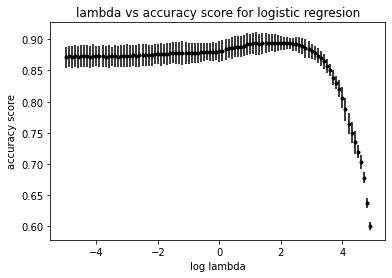

In [ ]:
'''
    ploting results for lambda LR cross validation
'''
fig, ax = plt.subplots()
ax.set_title('lambda vs accuracy score for logistic regresion')
ax.set_xlabel('log lambda')
ax.set_ylabel('accuracy score')
ax.errorbar([x for x in np.arange(-5,5,0.1)], grid_results_lr.cv_results_['mean_test_score'], yerr = grid_results_lr.cv_results_['std_test_score'], fmt='.k', linestyle='None')

best_lambda_lr = grid_results_lr.best_params_['C']
print(best_lambda_lr)

best lambda 0.019952623149689888

In [ ]:
grid_results_svm = grid_search_svm.fit(train_X,train_y)

Best params for svm are:  7.943282347243081 rbf
7.943282347243081
rbf


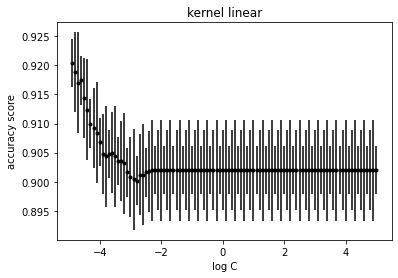

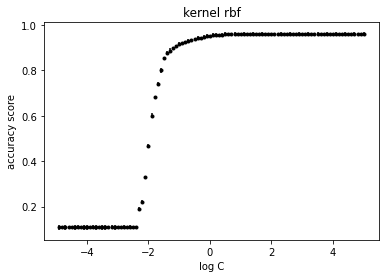

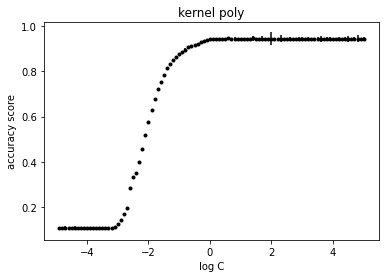

In [ ]:
'''
    ploting results for SVM parameters with cross validation:
     --- log C
     --- kernel function
'''

fig, ax1 = plt.subplots()
ax1.set_title('kernel linear')  
ax1.set_xlabel('log C')
ax1.set_ylabel('accuracy score')
ax1.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][::3], yerr = grid_results_svm.cv_results_['std_test_score'][:100] ,label= 'with kernel linear', fmt='.k', linestyle='None')
  
fig, ax2 = plt.subplots()
ax2.set_title('kernel rbf')  
ax2.set_xlabel('log C')
ax2.set_ylabel('accuracy score')
ax2.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][1::3], yerr = grid_results_svm.cv_results_['std_test_score'][100:200], label= 'with kernel rbf', fmt='.k', linestyle='None')

fig, ax3 = plt.subplots()
ax3.set_title('kernel poly')  
ax3.set_xlabel('log C')
ax3.set_ylabel('accuracy score')
ax3.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][2::3], yerr = grid_results_svm.cv_results_['std_test_score'][200:300] ,label= 'with kernel linear', fmt='.k', linestyle='None')

best_C_svm = grid_results_svm.best_params_['C']
best_kernel_svm = grid_results_svm.best_params_['kernel']


print('Best params for svm are: ', best_C_svm, best_kernel_svm)
print(best_C_svm)
print(best_kernel_svm)

In [ ]:
grid_results_NN = grid_search_NN.fit(train_X,train_y)

Best params for FF NN are:  (320,) logistic adam


<ErrorbarContainer object of 3 artists>

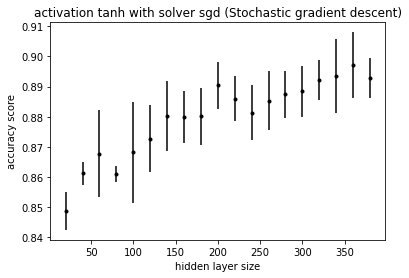

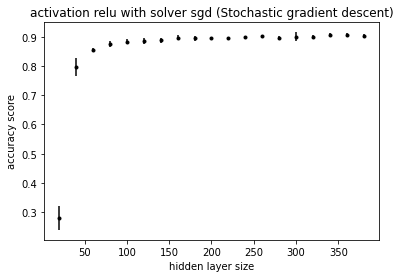

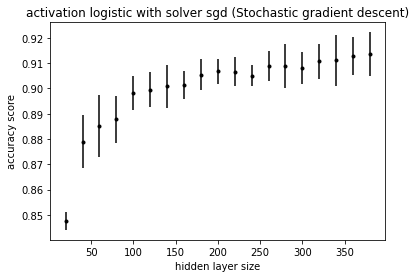

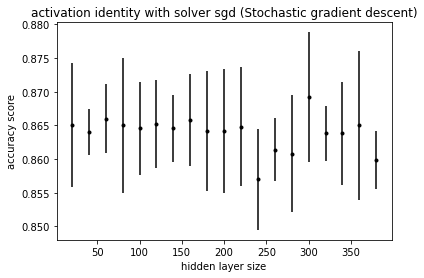

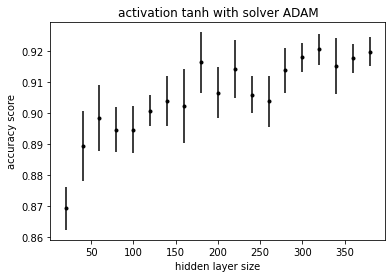

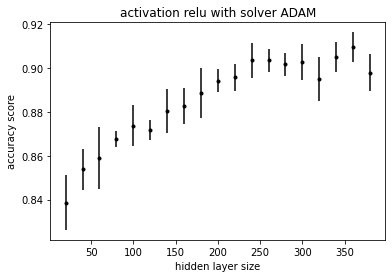

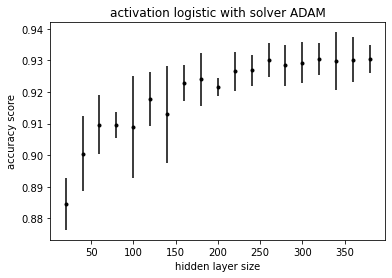

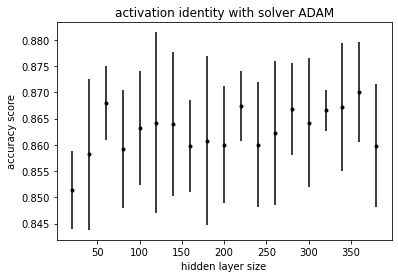

In [25]:
'''
    ploting results for MLP parameters with cross validation:
     --- hidden layer size 
     --- activation (identity, logistic/sigmoid, tanh, RELU)
     --- solver (SGD, ADAM)
'''

best_hidden_layer_sizes_NN = grid_results_NN.best_params_['hidden_layer_sizes']
best_activation_NN = grid_results_NN.best_params_['activation']
best_solver_NN = grid_results_NN.best_params_['solver']

print('Best params for FF NN are: ', best_hidden_layer_sizes_NN, best_activation_NN, best_solver_NN)

if not isinstance(hidden_layer_sizes,list):
  hidden_layer_sizes = [x[0] for x in hidden_layer_sizes]
M = len(hidden_layer_sizes)

fig, ax1 = plt.subplots()
ax1.set_title('activation tanh with solver sgd (Stochastic gradient descent)')  
ax1.set_xlabel('hidden layer size')
ax1.set_ylabel('accuracy score')
ax1.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][:2*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][:2*M:2], fmt='.k', linestyle='None')
  
fig, ax2 = plt.subplots()
ax2.set_title('activation relu with solver sgd (Stochastic gradient descent)')  
ax2.set_xlabel('hidden layer size')
ax2.set_ylabel('accuracy score')
ax2.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][2*M:4*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][2*M:4*M:2] , fmt='.k', linestyle='None')

fig, ax3 = plt.subplots()
ax3.set_title('activation logistic with solver sgd (Stochastic gradient descent)')  
ax3.set_xlabel('hidden layer size')
ax3.set_ylabel('accuracy score')
ax3.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][4*M:6*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][4*M:6*M:2] , fmt='.k', linestyle='None')

fig, ax4 = plt.subplots()
ax4.set_title('activation identity with solver sgd (Stochastic gradient descent)')  
ax4.set_xlabel('hidden layer size')
ax4.set_ylabel('accuracy score')
ax4.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][6*M:8*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][6*M:8*M:2] , fmt='.k', linestyle='None')

fig, ax5 = plt.subplots()
ax5.set_title('activation tanh with solver ADAM')  
ax5.set_xlabel('hidden layer size')
ax5.set_ylabel('accuracy score')
ax5.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][1:2*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][1:2*M:2], fmt='.k', linestyle='None')
  
fig, ax6 = plt.subplots()
ax6.set_title('activation relu with solver ADAM')  
ax6.set_xlabel('hidden layer size')
ax6.set_ylabel('accuracy score')
ax6.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][2*M+1:4*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][2*M+1:4*M:2] , fmt='.k', linestyle='None')

fig, ax7 = plt.subplots()
ax7.set_title('activation logistic with solver ADAM')  
ax7.set_xlabel('hidden layer size')
ax7.set_ylabel('accuracy score')
ax7.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][4*M+1:6*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][4*M+1:6*M:2] , fmt='.k', linestyle='None')

fig, ax8 = plt.subplots()
ax8.set_title('activation identity with solver ADAM')  
ax8.set_xlabel('hidden layer size')
ax8.set_ylabel('accuracy score')
ax8.errorbar(hidden_layer_sizes, grid_results_NN.cv_results_['mean_test_score'][6*M+1:8*M:2], yerr = grid_results_NN.cv_results_['std_test_score'][6*M+1:8*M:2] , fmt='.k', linestyle='None')
                               

## Experiments and results

In [18]:
# This code section upload the best hyperparameter in order to not go through
# the cross validation process
best_lambda_lr = 0.019952623149689888
best_kernel_svm = 'rbf'
best_C_svm = 7.943282347243081
best_hidden_layer_sizes_NN = (320,)
best_activation_NN = 'logistic'
best_solver_NN = 'adam'

lr fit: 1.1028757095336914 sec
svm fit: 1.0566120147705078 sec
mlp fit: 23.133063077926636 sec
lr predict: 0.06517720222473145 sec
svm predict: 15.117754459381104 sec
mlp predict: 0.550682544708252 sec


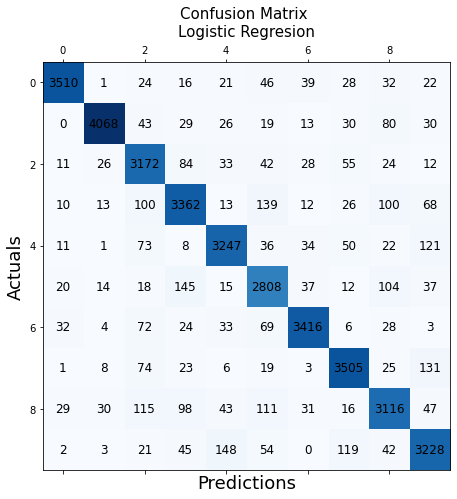

Acc lr:  0.9035675675675676
Precision lr: 0.9022454514163538
Recall lr: 0.90255280498519
F1 lr: 0.9021936095449965


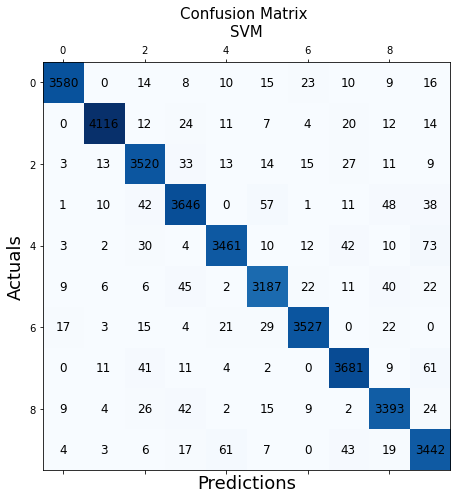

Acc svm:  0.960891891891892
Precision svm: 0.9606016000642903
Recall svm: 0.9606470315497943
F1 svm: 0.9605780722666066


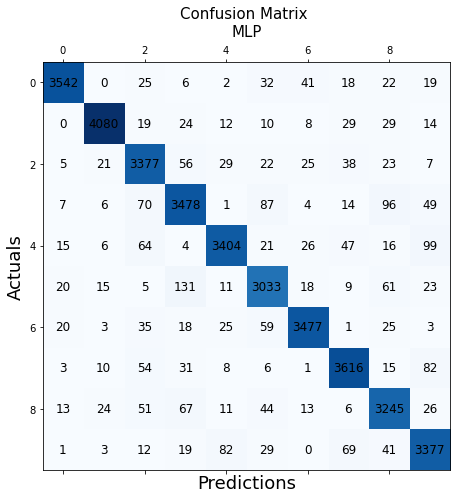

Acc MLP:  0.9359189189189189
Precision MLP: 0.9352861445568564
Recall MLP: 0.9352470935436388
F1 MLP: 0.9351813942959619


In [19]:
# Experiments with the found hyper parameters
start = time.time()
lr = LogisticRegression(solver='liblinear', 
                        penalty='l1',                      
                        C = best_lambda_lr,
                        random_state=0
                        ).fit(train_X, train_y)
end = time.time()
print(f'lr fit: {end-start} sec')

start = time.time()
svm_clf = svm.SVC(
              kernel= best_kernel_svm,
              C= best_C_svm,
              random_state=0
              ).fit(train_X,train_y)
end = time.time()
print(f'svm fit: {end-start} sec')

start = time.time()
nn = MLPClassifier(
                    hidden_layer_sizes = best_hidden_layer_sizes_NN,
                    activation = best_activation_NN,
                    solver = best_solver_NN,                    
                    random_state=0
                  ).fit(train_X,train_y)
end = time.time()
print(f'mlp fit: {end-start} sec')

start = time.time()
y_pred_lr = lr.predict(test_X)
end = time.time()
print(f'lr predict: {end-start} sec')

start = time.time()
y_pred_svm = svm_clf.predict(test_X)
end = time.time()
print(f'svm predict: {end-start} sec')

start = time.time()
y_pred_mlp = nn.predict(test_X)
end = time.time()
print(f'mlp predict: {end-start} sec')

conf_matrix = confusion_matrix(y_pred_lr, test_y)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion')
print(f'Acc lr: ' ,accuracy_score(y_pred_lr, test_y))
print(f'Precision lr: {precision_score(y_pred_lr, test_y, average="macro")}')
print(f'Recall lr: {recall_score(y_pred_lr, test_y, average="macro")}')
print(f'F1 lr: {f1_score(y_pred_lr, test_y, average="macro")}')

conf_matrix = confusion_matrix(y_pred_svm, test_y)
plot_conf_matrix(conf_matrix, title = ' \nSVM')
print(f'Acc svm: ' ,accuracy_score(y_pred_svm, test_y))
print(f'Precision svm: {precision_score(y_pred_svm, test_y, average="macro")}')
print(f'Recall svm: {recall_score(y_pred_svm, test_y, average="macro")}')
print(f'F1 svm: {f1_score(y_pred_svm, test_y, average="macro")}')

conf_matrix = confusion_matrix(y_pred_mlp, test_y)
plot_conf_matrix(conf_matrix, title = ' \nMLP')
print(f'Acc MLP: ' ,accuracy_score(y_pred_mlp, test_y))
print(f'Precision MLP: {precision_score(y_pred_mlp, test_y, average="macro")}')
print(f'Recall MLP: {recall_score(y_pred_mlp, test_y, average="macro")}')
print(f'F1 MLP: {f1_score(y_pred_mlp, test_y, average="macro")}')

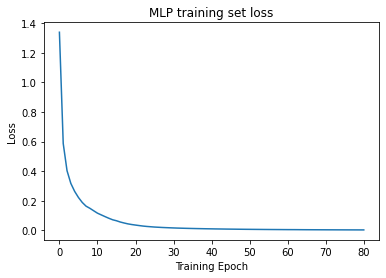

In [ ]:
# ploting loss of MLP model
fig, ax = plt.subplots()
ax.set_title('MLP training set loss')
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Loss')
ax.plot(nn.loss_curve_)